# Sentiment Analysis using RNN, LSTM and GRU

## 1. Loading and Preprocessing Data for retrieving labels

First part of the assignment is to match the labels of movie reviews using cornell polarity data sets.

Here, I first preprocess original_rt_snippets, negative and positive polarity files and match them to extract the labels for original_rt_snippets since the reviews in original_rt_snippets maintains the order as dataSentences from stanford. 

After extracting the labels, I preprocess the dataSentences and match them with original_rt_snippents from which I get the labels for dataSentences. 

After a lot of analysis of datasets, I realised that there are 1 or 2 different sentences in both data sets which I had to manually preprocess. There are a lot of duplicates as well in all the data sets. Over all, the data set was not properly put together.

In [69]:
import pandas as pd
import numpy as np
import re



dataSentences = pd.read_csv('/Users/sudheerkumar/Desktop/DL for NLP/Assignments/HW2/stanfordSentimentTreebank/datasetSentences.txt',sep = "\t",header = 0)
datasplit = pd.read_csv('/Users/sudheerkumar/Desktop/DL for NLP/Assignments/HW2/stanfordSentimentTreebank/datasetSplit.txt', delimiter = ",", header = 0)


name_pos = '/Users/sudheerkumar/Desktop/DL for NLP/Assignments/HW2/rt-polaritydata/rt-polaritydata/rt-polarity.pos'
name_neg = '/Users/sudheerkumar/Desktop/DL for NLP/Assignments/HW2/rt-polaritydata/rt-polaritydata/rt-polarity.neg'
original_snipp_file = '/Users/sudheerkumar/Desktop/DL for NLP/Assignments/HW2/stanfordSentimentTreebank/original_rt_snippets.txt'


# Loading all the processed original reviews, polarity_negative reviews and polarity_positive reviews into lists



def LoadAndProcess(filename):
    sentence_list = []
    with open(filename, 'rt', encoding = 'latin-1') as f:
        for line in f:
            line = line.lower()                     # changes to lower_case
            line = re.sub('<.*?>', '',line)         # removes tags   
            line = re.sub('<[a-zA-Z]','',line)      # removes text of form <xyz

            line = re.sub(r'[^\w]','',line)         # removes everything except a-zA-Z0-9 and underscore
            line = re.sub(r'[0-9]','',line)         # removes numbers
            line = re.sub(r'[^\x00-\x7f]','',line)  # removes non ascii characters
            sentence_list.append(line)
    return sentence_list


original_snipp = LoadAndProcess(original_snipp_file)
file_pos = LoadAndProcess(name_pos)
file_neg = LoadAndProcess(name_neg)


In [3]:
#Matching original_rt reviews with polairty negative and positive reviews to retrieve labels in order of original_rt_reviews

original_rt_labels = []

for line in original_snipp:
    if any(line == text for text in file_pos):
        original_rt_labels.append(1)
    elif any(line == text for text in file_neg):
        original_rt_labels.append(0)
    elif line =="ihavenoproblemwithdifficultmoviesormoviesthatasktheaudiencetomeetthemhalfwayandconnectthedotsinsteadofhavingthingsallspelledoutbutfirstyouhavetogivetheaudienceareasontowanttoputforthateffort" :
        original_rt_labels.append(0)
    else:
        print(line )

# rt-polarity.neg has additional letters at the end to the above line as mentioned below. The data set is a complete mess.
# i have no problem with " difficult " movies , or movies that ask the audience to meet them halfway and connect the dots instead of having things all spelled out . but first , you have to give the audience a reason to <b>want</b> to put for that effort , and " i
# Hence adding the label manually.

In [4]:
#  Function to process the dataSentences that can be used to compare with original_rt_snippets
def sentence_manipulate(sentence):
    sentence= sentence.lower()
    sentence = re.sub(r'[^\w]','',sentence)
    sentence = re.sub(r'[0-9]','',sentence)
    sentence = re.sub(r'[^\x00-\x7f]','',sentence)
    #sentence = re.sub(r'[^a-zA-Z0-9]','',sentence)
    sentence = sentence.replace("lrb", "")
    sentence = sentence.replace("rrb","")
    return sentence

# Function that returns the first index element that matches with the substring
def getFirstMatchedIndexPosition(substring, listOfstrings):
    for i in range(len(listOfstrings)):
        if substring in listOfstrings[i]:
            return i


# Returns the labels for each sentence in dataSentences in order
final_labels=[]

for sentence in list(dataSentences["sentence"].values):
    sentence= sentence_manipulate(sentence)
    ind = getFirstMatchedIndexPosition(sentence,original_snipp)
    final_labels.append(original_rt_labels[ind])
    original_snipp[ind]= original_snipp[ind].replace(sentence,"$$",1)  
    # Removes the sentence that has been matched already to avoid confusion and match with the correct original_snippet when same set of characters appear again.


In [5]:
# Adding Labels column to dataSentences dataframe

dataSentences["labels"]=final_labels

In [6]:
dataSentences.tail()

,sentence_index,sentence,labels
11850,11851,A real snooze .,0
11851,11852,No surprises .,0
11852,11853,We 've seen the hippie-turned-yuppie plot befo...,1
11853,11854,Her fans walked out muttering words like `` ho...,0
11854,11855,In this case zero .,0


## Preprocessing the data for creating word embeddings

In [67]:
from nltk.corpus import stopwords
import string 

#Function to clean the sentences
def clean_sentence(sentence):
    
    sentence = sentence.translate(string.punctuation)
    sentence = sentence.lower()
    sentence = re.sub(r"[^A-Za-z0-9]", " ",sentence)
    sentence = re.sub(r'[,!...\/+-=]'," ", sentence)
    sentence = sentence.replace("lrb", "")
    sentence = sentence.replace("rrb","")
    #stopwrds = set(stopwords.words("english"))
    #Tried removing stopwords but there was no big improvement in accuracy
    words = sentence.split()
    words = [word for word in words if len(word) >= 3]
    sentence = " ".join(words)
    return sentence
    
#Cleaning the each data of sentences column and replacing the original form    
dataSentences["sentence"] = dataSentences["sentence"] .map(lambda x: clean_sentence(x))


In [8]:
dataSentences.head()

,sentence_index,sentence,labels
0,1,the rock destined the century new conan and th...,1
1,2,the gorgeously elaborate continuation the lord...,1
2,3,effective but too tepid biopic,1
3,4,you sometimes like the movies have fun wasabi ...,1
4,5,emerges something rare issue movie that honest...,1


In [9]:
#Replacing empty sentences if any (because, I removed words that have length less than 3)  with "good" if label is 1 or "bad" if label is 0.

for ind in dataSentences.index:
    if dataSentences["sentence"][ind] =='' and dataSentences["labels"][ind]==1:
        dataSentences["sentence"][ind]= "good"
    elif dataSentences["sentence"][ind] =='' and dataSentences["labels"][ind]==0:
        dataSentences["sentence"][ind] = "bad"

/Users/sudheerkumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/sudheerkumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [10]:
# Splitting the dataset into train, validation and test using datasplit file

data_train = dataSentences[datasplit["splitset_label"]==1]

X_train = data_train["sentence"]
Y_train = data_train["labels"].values

data_test = dataSentences[datasplit["splitset_label"]==2]

X_test = data_test["sentence"]
Y_test = data_test["labels"] .values

data_validate = dataSentences[datasplit["splitset_label"]==3]

X_validate = data_validate["sentence"]
Y_validate = data_validate["labels"].values

In [11]:
# Creating Word Embeddings 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences



# Vectorizing the sentences in to integer indices

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(dataSentences["sentence"])
sequences = tokenizer_obj.texts_to_sequences(dataSentences["sentence"])

# Dictionary of all the unique words and their indices in the order of their occuring frequency
word_index = tokenizer_obj.word_index

# Max Length of a sentence
max_length = max([len(sentence) for sentence in sequences])

# No of unique words
vocabulary_size = len(word_index) + 1

print('Number of Unique words:', len(word_index) )
print('Actual Max Length of a sentence', max_length)

# Tokenized sentences

X_train_tokens= tokenizer_obj.texts_to_sequences(X_train)
X_validate_tokens = tokenizer_obj.texts_to_sequences(X_validate)
X_test_tokens= tokenizer_obj.texts_to_sequences(X_test)

def Padded_sequences(max_sequence_length):
    X_train_pad = pad_sequences(X_train_tokens, maxlen = max_sequence_length, padding ="post")
    X_validate_pad = pad_sequences(X_validate_tokens, maxlen = max_sequence_length, padding ="post")
    X_test_pad = pad_sequences(X_test_tokens, maxlen = max_sequence_length, padding ="post")
    
    return X_train_pad,X_validate_pad,X_test_pad

Using TensorFlow backend.


Number of Unique words: 17478
Actual Max Length of a sentence 39


In [12]:
#Input_dim is the dimension of Word Vectors

def embedding_matrix(input_dim):
    
    # Saving the word embeddings from glove model in a dictionary
    embeddings_index = dict()
    filename=''
    if input_dim ==300:
        filename = '/Users/sudheerkumar/Desktop/DL for NLP/Assignments/HW2/glove.6B/glove.6B.300d.txt'
    elif input_dim == 100:
        filename = '/Users/sudheerkumar/Desktop/DL for NLP/Assignments/HW2/glove.6B/glove.6B.100d.txt'
    elif input_dim ==50:
        filename = '/Users/sudheerkumar/Desktop/DL for NLP/Assignments/HW2/glove.6B/glove.6B.50d.txt'
    
    file = open(filename)
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:])
        embeddings_index[word] = coefs
    file.close()
    
    # Mapping the glove embeddings to each word of vocabulary and creating a matrix of word vectors
    embedding_matrix = np.zeros((vocabulary_size,input_dim))
    for word, index in word_index.items():
        if index > vocabulary_size - 1:
            break
        else:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector
    return embedding_matrix
    


## 2. Implementing RNN, LSTM, and GRU models for the sentiment classification task.

In [13]:
# Building Model
from keras.models import Sequential
from keras.layers import Dense, Masking, LSTM, SimpleRNN, GRU, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras import optimizers
def RNN(wordvector_dim,embedding_matrix,sequence_length,learning_rate,hiddenUnits):
    model = Sequential()
    #the model must be informed that some part of the data is actually padding and should be ignored. Hence mask_zero = True
    model.add(Embedding(vocabulary_size, wordvector_dim,embeddings_initializer = Constant(embedding_matrix), input_length = sequence_length, trainable = False, mask_zero =True))
    model.add(SimpleRNN(units = hiddenUnits,input_shape=[None,sequence_length], return_sequences=False))
    model.add(Dense(1,activation = 'sigmoid'))
    adam = optimizers.Adam(lr = learning_rate)
    model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
    print(model.summary())
    print("------------------------------------\n")
    return model


def LSTM1(wordvector_dim,embedding_matrix,sequence_length,learning_rate,hiddenUnits):
    model = Sequential()
    #the model must be informed that some part of the data is actually padding and should be ignored. Hence mask_zero = True
    model.add(Embedding(vocabulary_size, wordvector_dim,embeddings_initializer = Constant(embedding_matrix), input_length = sequence_length, trainable = False,mask_zero =True))
    model.add(LSTM(units=hiddenUnits,input_shape=[None,sequence_length],return_sequences = False))
    model.add(Dense(1,activation = 'sigmoid'))
    adam = optimizers.Adam(lr = learning_rate)
    model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
    print(model.summary())
    print("------------------------------------\n")
    return model

def GRU1(wordvector_dim,embedding_matrix,sequence_length,learning_rate,hiddenUnits):
    model = Sequential()
    #the model must be informed that some part of the data is actually padding and should be ignored. Hence mask_zero = True
    model.add(Embedding(vocabulary_size, 300,embeddings_initializer = Constant(embedding_matrix), input_length = sequence_length, trainable = False,mask_zero =True))
    model.add(GRU(units = hiddenUnits,input_shape=[None,sequence_length],return_sequences=False))
    model.add(Dense(1,activation = 'sigmoid'))
    adam = optimizers.Adam(lr = learning_rate)
    model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
    print(model.summary())
    print("------------------------------------\n")
    return model




In [14]:
import matplotlib.pyplot as plt
import math
from pylab import MaxNLocator

def plot_results(results,lr_rate,batch_size,seq_length):
    res = pd.DataFrame(results.history)
    res['epoch'] = results.epoch
    
    plt.figure()
    #plot for Accuracy
    #a.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.plot(res['epoch'], res['acc'],label='Train accuracy')
    plt.plot(res['epoch'], res['val_acc'],label = 'Val accuracy')
    plt.ylim([0,math.ceil(max(res['acc']))])
    plt.title("Learning_Rate={},Batch_Size={},Sequence_Length = {}".format(lr_rate,batch_size,seq_length))
    plt.legend()
    
    
    plt.figure()
    #b.xaxis.set_major_locator(MaxNLocator(integer=True))
    #plot for Loss
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(res['epoch'], res['loss'],label='Train loss')
    plt.plot(res['epoch'], res['val_loss'],label = 'Val loss')
    plt.ylim([0,math.ceil(max(res['val_loss']))])
    plt.title("Learning_Rate={},Batch_Size={},Sequence_Length = {}".format(lr_rate,batch_size,seq_length))
    plt.legend()
    plt.show()
    print("Validation Accuracy : {}".format(res['val_acc'].iloc[-1]))
    print("Training Accuracy   : {}". format(res['acc'].iloc[-1]))
    print("---------------------------------------------")

## Evaluating the learning Parameters

In [24]:
# Learning Parameters
learning_rate = [0.0001,0.001]
batch_size = [128,512]
sequence_length = [25, max_length]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 25, 300)           5243700   
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 256)               142592    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 5,386,549
Trainable params: 142,849
Non-trainable params: 5,243,700
_________________________________________________________________
None
------------------------------------



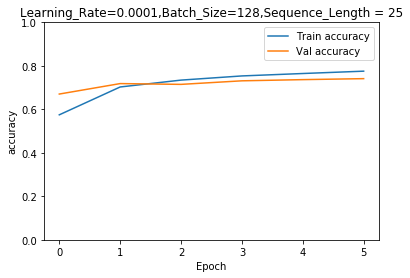

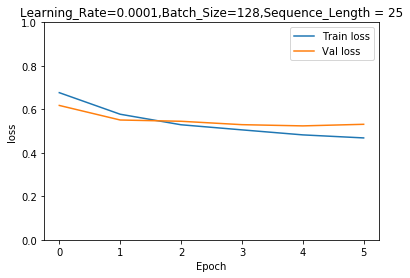

Validation Accuracy : 0.7411444131403376
Training Accuracy   : 0.7755149812734082
---------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 39, 300)           5243700   
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, 256)               142592    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 5,386,549
Trainable params: 142,849
Non-trainable params: 5,243,700
_________________________________________________________________
None
------------------------------------



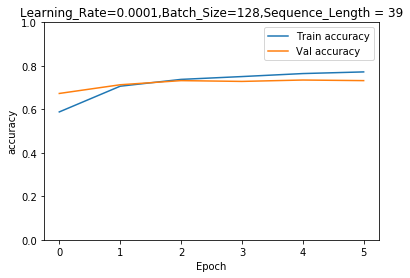

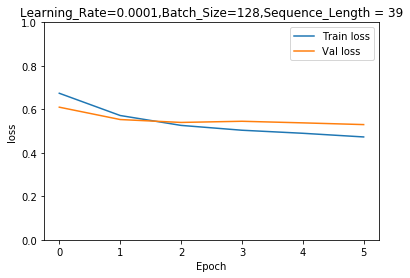

Validation Accuracy : 0.7320617629007032
Training Accuracy   : 0.7721207867400923
---------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 25, 300)           5243700   
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 256)               142592    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 5,386,549
Trainable params: 142,849
Non-trainable params: 5,243,700
_________________________________________________________________
None
------------------------------------



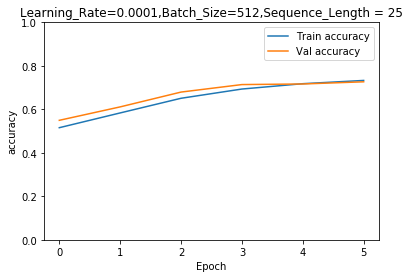

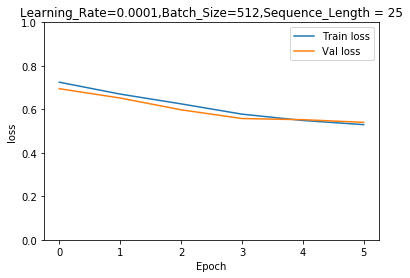

Validation Accuracy : 0.7266121696711236
Training Accuracy   : 0.7329119856884417
---------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 39, 300)           5243700   
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 256)               142592    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 5,386,549
Trainable params: 142,849
Non-trainable params: 5,243,700
_________________________________________________________________
None
------------------------------------



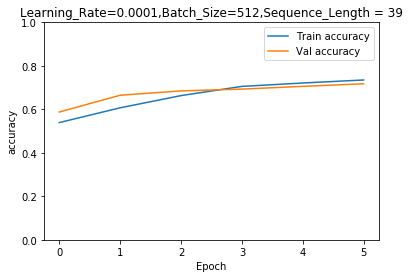

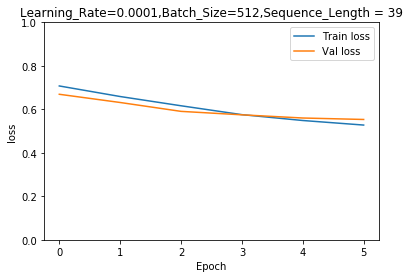

Validation Accuracy : 0.7175295191608051
Training Accuracy   : 0.7350187261452835
---------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 25, 300)           5243700   
_________________________________________________________________
simple_rnn_15 (SimpleRNN)    (None, 256)               142592    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 5,386,549
Trainable params: 142,849
Non-trainable params: 5,243,700
_________________________________________________________________
None
------------------------------------



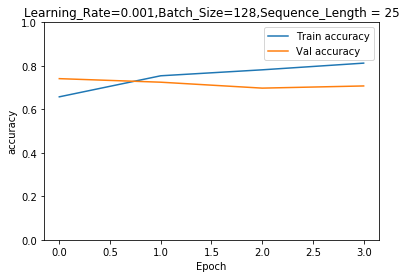

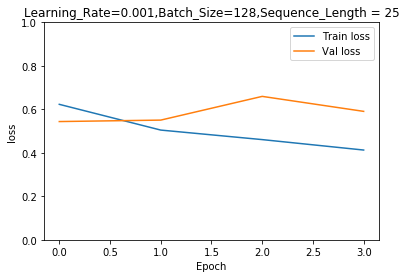

Validation Accuracy : 0.7075385999181507
Training Accuracy   : 0.8124999997767617
---------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 39, 300)           5243700   
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 256)               142592    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 257       
Total params: 5,386,549
Trainable params: 142,849
Non-trainable params: 5,243,700
_________________________________________________________________
None
------------------------------------



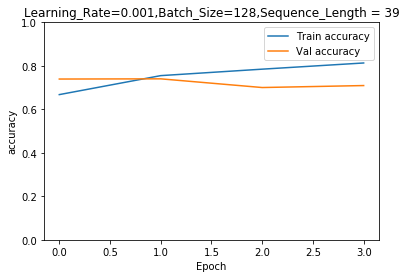

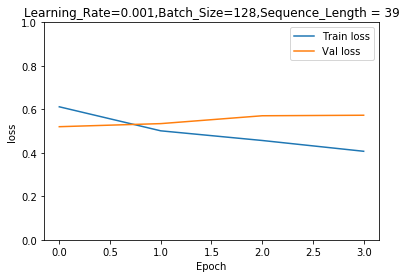

Validation Accuracy : 0.7093551332142871
Training Accuracy   : 0.8132022469677729
---------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 25, 300)           5243700   
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, 256)               142592    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 5,386,549
Trainable params: 142,849
Non-trainable params: 5,243,700
_________________________________________________________________
None
------------------------------------



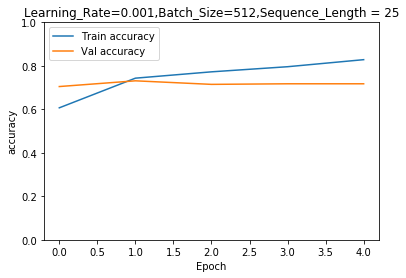

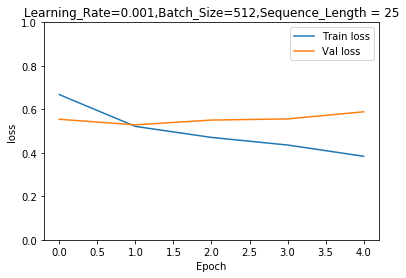

Validation Accuracy : 0.717529519485626
Training Accuracy   : 0.8284176038892082
---------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 39, 300)           5243700   
_________________________________________________________________
simple_rnn_18 (SimpleRNN)    (None, 256)               142592    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 257       
Total params: 5,386,549
Trainable params: 142,849
Non-trainable params: 5,243,700
_________________________________________________________________
None
------------------------------------



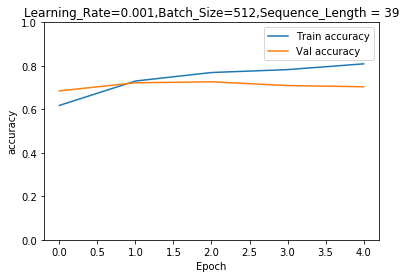

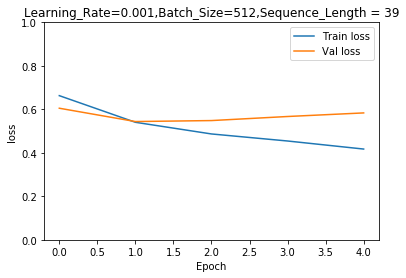

Validation Accuracy : 0.7039055416088121
Training Accuracy   : 0.809222846665186
---------------------------------------------


In [25]:
from keras.callbacks import EarlyStopping
# Setting constant patience level for early stopping criteria
hidden_units = 256
for rate in learning_rate:
    for size in batch_size:
        for length in sequence_length:
            model = RNN(300,embedding_matrix(300),length,rate,hidden_units)
            early_stop = EarlyStopping(monitor='val_loss', patience=3)
            X_train_pad = Padded_sequences(length)[0]
            X_validate_pad = Padded_sequences(length)[1]
            results = model.fit(X_train_pad, Y_train, batch_size = size, epochs = 6, validation_data=(X_validate_pad, Y_validate), verbose =0,callbacks=[early_stop])
            plot_results(results,rate,size,length)


From the above graphs, highest validation accuracy of 74.11% is achieved when Learning Rate = 0.0001, Batch_Size = 128, Sequence Length = 25. Corresponding Training accuracy is 77.55%. When learning Rate = 0.001, difference between validation accuracy and training accuracy was increasing as the number of epoch was increasing, which means the model was overfitting. And, the same pattern is observed between models having learning rate = 0.0001. Hence, below parameters were chosen.

learning rate = 0.0001
Batch_size = 128
Sequence Length = 25 .

## Experimenting with Architecture

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 25, 300)           5243700   
_________________________________________________________________
simple_rnn_23 (SimpleRNN)    (None, 128)               54912     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 129       
Total params: 5,298,741
Trainable params: 55,041
Non-trainable params: 5,243,700
_________________________________________________________________
None
------------------------------------

HIDDEN UNITS = 128


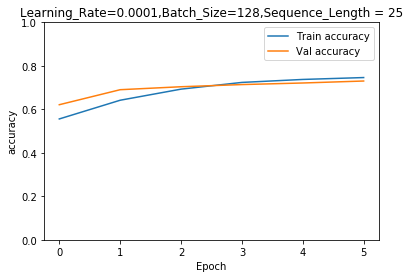

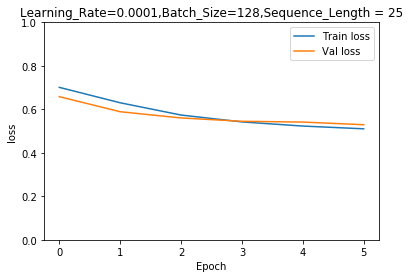

Validation Accuracy : 0.7302452299293878
Training Accuracy   : 0.7461376404494382
---------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 25, 300)           5243700   
_________________________________________________________________
simple_rnn_24 (SimpleRNN)    (None, 512)               416256    
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 513       
Total params: 5,660,469
Trainable params: 416,769
Non-trainable params: 5,243,700
_________________________________________________________________
None
------------------------------------

HIDDEN UNITS = 512


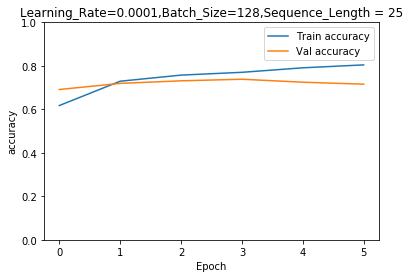

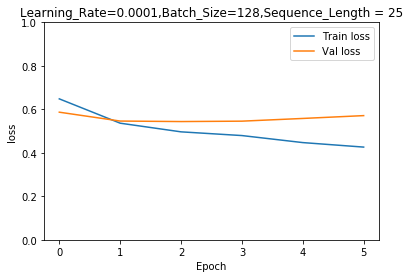

Validation Accuracy : 0.7157129897083834
Training Accuracy   : 0.8044241570801324
---------------------------------------------


In [30]:
# best parameters from above:
learningRate = 0.0001
BatchSize = 128
SequenceLength = 25

#Number of Hidden Units

hidden_units_list =[int(hidden_units/2), int(hidden_units*2)] 
for hidden_unit in hidden_units_list:
    model = RNN(300,embedding_matrix(300),SequenceLength,learningRate,hidden_unit)
    early_stop = EarlyStopping(monitor='val_loss', patience=3)
    X_train_pad = Padded_sequences(SequenceLength)[0]
    X_validate_pad = Padded_sequences(SequenceLength)[1]
    results = model.fit(X_train_pad, Y_train, batch_size = BatchSize, epochs = 6, validation_data=(X_validate_pad, Y_validate), verbose =0,callbacks=[early_stop])
    print("HIDDEN UNITS = {}".format(hidden_unit))
    plot_results(results,learningRate,BatchSize,SequenceLength)




From the above graphs, we see that validation accuracy is 73.02% for hidden units = 128 and 71.56% for hidden units = 512. Also, training accuracy is 80.04% for hidden units = 512 when compared to 74.61% of training accuracy for hidden units = 128. The model reached to 74.11%(our base model) with optimal 256 units and started to over fit the data from that as hidden units increased. Too many neurons generally tend to over fit the data.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 12, 300)           5243700   
_________________________________________________________________
simple_rnn_28 (SimpleRNN)    (None, 256)               142592    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 257       
Total params: 5,386,549
Trainable params: 142,849
Non-trainable params: 5,243,700
_________________________________________________________________
None
------------------------------------

Sequence_Length = 12


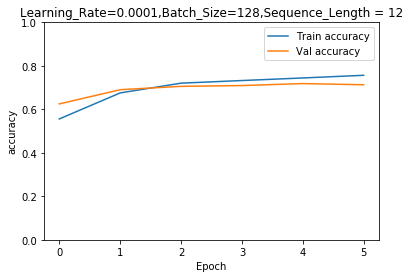

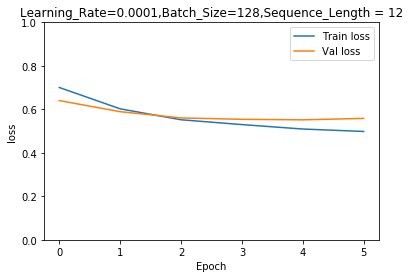

Validation Accuracy : 0.7129881921732675
Training Accuracy   : 0.7565543071161048
---------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 50, 300)           5243700   
_________________________________________________________________
simple_rnn_29 (SimpleRNN)    (None, 256)               142592    
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 257       
Total params: 5,386,549
Trainable params: 142,849
Non-trainable params: 5,243,700
_________________________________________________________________
None
------------------------------------

Sequence_Length = 50


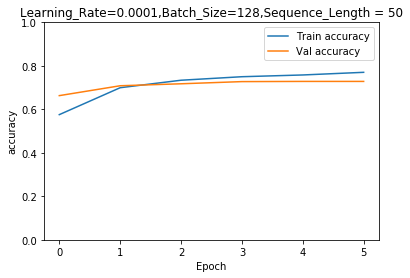

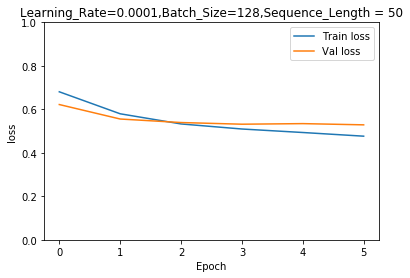

Validation Accuracy : 0.7284287010724712
Training Accuracy   : 0.7702481275640624
---------------------------------------------


In [34]:
# Sequence Length 

Sequence_length_list = [int(SequenceLength/2), int(SequenceLength*2)]
for length in Sequence_length_list:
    model = RNN(300,embedding_matrix(300),length,learningRate,hidden_units)
    early_stop = EarlyStopping(monitor='val_loss', patience=3)
    X_train_pad = Padded_sequences(length)[0]
    X_validate_pad = Padded_sequences(length)[1]
    results = model.fit(X_train_pad, Y_train, batch_size = BatchSize, epochs = 6, validation_data=(X_validate_pad, Y_validate), verbose =0,callbacks=[early_stop])
    print("Sequence_Length = {}".format(length))
    plot_results(results,learningRate,BatchSize,length)

    

From the above graphs, we observe that validation accuracy is 72.84% when sequence length is 50 and 71.30% when sequence length is 12. Theoretically, high sequence length implies more information and hence more accurately the model learns. This equivalent to having more features that represent the data. Even though there is a large difference in length between 12 and 50, we see that there is no big difference in validation accuracy. This is because our actual max sequence length is 39, which means the model with sequence length 50 has padded more zeroes to each and every sentence sequence that is not useful to the model.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 25, 50)            873950    
_________________________________________________________________
simple_rnn_30 (SimpleRNN)    (None, 256)               78592     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 257       
Total params: 952,799
Trainable params: 78,849
Non-trainable params: 873,950
_________________________________________________________________
None
------------------------------------

Dimension = 50


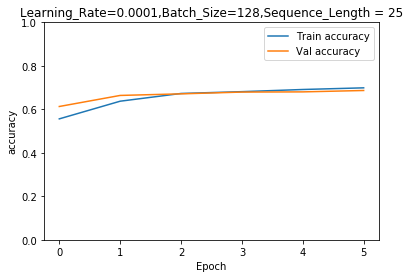

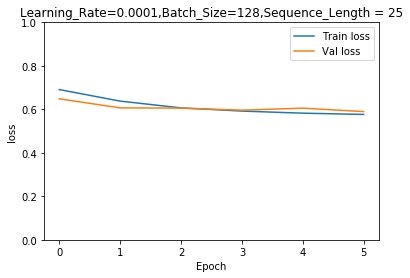

Validation Accuracy : 0.6866485032030499
Training Accuracy   : 0.6988529962546817
---------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 25, 100)           1747900   
_________________________________________________________________
simple_rnn_31 (SimpleRNN)    (None, 256)               91392     
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 257       
Total params: 1,839,549
Trainable params: 91,649
Non-trainable params: 1,747,900
_________________________________________________________________
None
------------------------------------

Dimension = 100


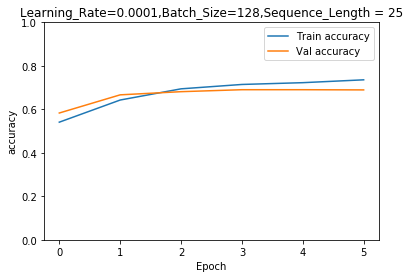

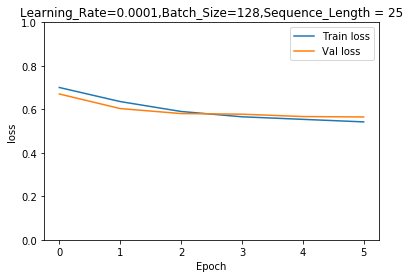

Validation Accuracy : 0.689373297868914
Training Accuracy   : 0.7357209735595331
---------------------------------------------


In [35]:
# Word Embedding Dimensions
# To avoid repetition,I'm only using 50 and 100 since my base model was built on 300 word vector embeddings.
vec_dimensions = [50,100]
for dim in vec_dimensions:
    model = RNN(dim,embedding_matrix(dim),SequenceLength,learningRate,hidden_units)
    early_stop = EarlyStopping(monitor='val_loss', patience=3)
    X_train_pad = Padded_sequences(SequenceLength)[0]
    X_validate_pad = Padded_sequences(SequenceLength)[1]
    results = model.fit(X_train_pad, Y_train, batch_size = BatchSize, epochs = 6, validation_data=(X_validate_pad, Y_validate), verbose =0,callbacks=[early_stop])
    print("Dimension = {}".format(dim))
    plot_results(results,learningRate,BatchSize,SequenceLength)
    

From the above graphs and our base model, we observe that the validation accuracy increases with increase in word vector dimension from 68.66% when dim = 50 to 74.11% when dim = 300. This is expected because we have used pre trained vectors that were built on wikipedia data set that is different from our dataset. Hence, the vectors wont represent accurately. And, since more features(dimension) implies that it carries more information about a word, model with high dimension has high accuracy. 

## Optimal hyperparameters


Using all the above information, the optimal hyperparameters are as below.

Learning Rate = 0.0001

Batch Size = 128

Hidden Units = 256

Sequence Length = 25

Dimension = 300

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 25, 300)           5243700   
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 256)               142592    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 5,386,549
Trainable params: 142,849
Non-trainable params: 5,243,700
_________________________________________________________________
None
------------------------------------



W1025 22:23:54.162090 4658881984 deprecation_wrapper.py:119] From /Users/sudheerkumar/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



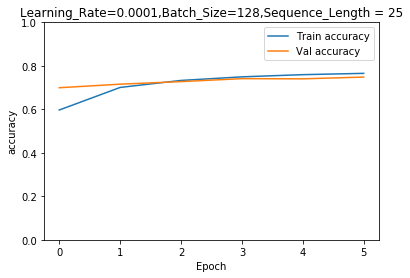

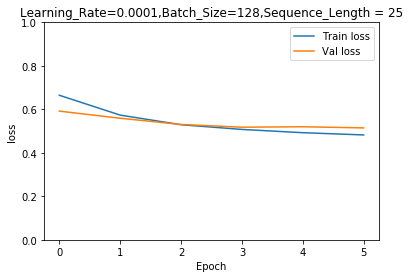

Validation Accuracy : 0.7484105345230553
Training Accuracy   : 0.7654494379790088
---------------------------------------------


In [19]:
## Building RNN LSTM and GRU Models
from keras.callbacks import EarlyStopping
Learn_Rate = 0.0001
batchSize = 128
HiddenUnits = 256
Seq_Length = 25
Dimension = 300

#RNN
RNN_best_model = RNN(Dimension,embedding_matrix(Dimension),Seq_Length,Learn_Rate,HiddenUnits)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
X_train_pad = Padded_sequences(Seq_Length)[0]
X_validate_pad = Padded_sequences(Seq_Length)[1]
RNN_results = RNN_best_model.fit(X_train_pad, Y_train, batch_size = batchSize, epochs = 6, validation_data=(X_validate_pad, Y_validate), verbose =0,callbacks=[early_stop])
plot_results(RNN_results,Learn_Rate,batchSize,Seq_Length)



In [58]:
# Function that evaluates metric scores
def scores(Y_true, Y_predict):
    Y_predict_list = [i[0] for i in Y_predict]
    a=precision_recall_fscore_support(Y_true, Y_predict_list, pos_label =1, average = 'binary')
    print("Accuracy:{}%\nPrecision:{}%\nRecall:{}%\nFscore:{}%\n".format(100*accuracy_score(Y_true, Y_predict_list),100*a[0],100*a[1],100*a[2]))
    

In [59]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
X_test_pad = Padded_sequences(Seq_Length)[2]
Y_test_predict_RNN = RNN_best_model.predict_classes(X_test_pad)

scores(Y_test,Y_test_predict_RNN)

Accuracy:74.38914027149322%
Precision:74.23371647509579%
Recall:72.29477611940298%
Fscore:73.25141776937618%



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 25, 300)           5243700   
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               570368    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 5,814,325
Trainable params: 570,625
Non-trainable params: 5,243,700
_________________________________________________________________
None
------------------------------------



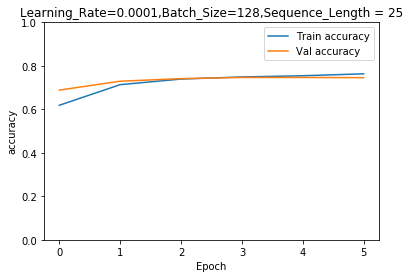

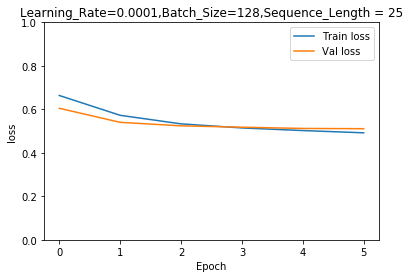

Validation Accuracy : 0.745685742076801
Training Accuracy   : 0.7633426968524518
---------------------------------------------


In [50]:
#LSTM
LSTM_best_model = LSTM1(Dimension,embedding_matrix(Dimension),Seq_Length,Learn_Rate,HiddenUnits)
X_train_pad = Padded_sequences(Seq_Length)[0]
X_validate_pad = Padded_sequences(Seq_Length)[1]
LSTM_results = LSTM_best_model.fit(X_train_pad, Y_train, batch_size = batchSize, epochs = 6, validation_data=(X_validate_pad, Y_validate), verbose =0,callbacks=[early_stop])
plot_results(LSTM_results,Learn_Rate,batchSize,Seq_Length)




In [63]:
Y_test_predict_LSTM = LSTM_best_model.predict_classes(X_test_pad)
scores(Y_test,Y_test_predict_LSTM)

Accuracy:75.15837104072398%
Precision:73.66515837104073%
Recall:75.93283582089553%
Fscore:74.78180983004134%



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 25, 300)           5243700   
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               427776    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 5,671,733
Trainable params: 428,033
Non-trainable params: 5,243,700
_________________________________________________________________
None
------------------------------------



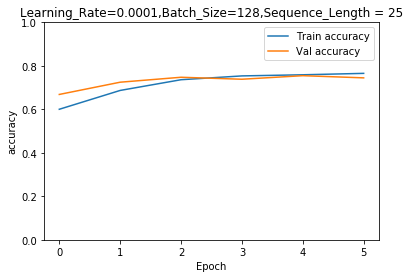

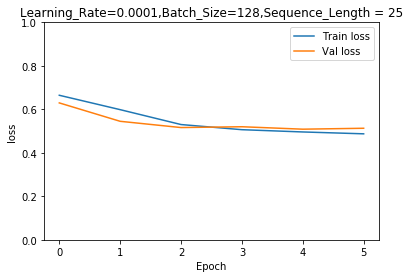

Validation Accuracy : 0.7447774765385378
Training Accuracy   : 0.7654494379790088
---------------------------------------------


In [65]:
# GRU 
GRU_best_model = GRU1(Dimension,embedding_matrix(Dimension),Seq_Length,Learn_Rate,HiddenUnits)
X_train_pad = Padded_sequences(Seq_Length)[0]
X_validate_pad = Padded_sequences(Seq_Length)[1]
GRU_results = GRU_best_model.fit(X_train_pad, Y_train, batch_size = batchSize, epochs = 6, validation_data=(X_validate_pad, Y_validate), verbose =0,callbacks=[early_stop])
plot_results(GRU_results,Learn_Rate,batchSize,Seq_Length)

In [66]:
Y_test_predict_GRU = GRU_best_model.predict_classes(X_test_pad)
scores(Y_test,Y_test_predict_GRU)

Accuracy:75.29411764705883%
Precision:72.75086505190312%
Recall:78.45149253731343%
Fscore:75.49371633752243%



From the above results, we see that GRU has the highest test accuracy of 75.30% where as LSTM has 75.16% and Simple RNN has 74.39%. GRU also has all other metrics higher than others except for precision. Since all the accuracies are almost close, it implies that there seems no effect of vanishing gradient problem.